In [1]:
!pip install gym
!pip install box2d_py

     |████████████████████████████████| 450kB 2.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/progettoDataDriven/gym_BipedalWalker-v3/TD3-conf1

/content/drive/.shortcut-targets-by-id/1TyolH62paiFvrPtkZ3ZJunv4rqrxh7Nz/progettoDataDriven/gym_BipedalWalker-v3/TD3/1_TD3-PyTorch-BipedalWalker-v3


Episode: 100/10000,	Mean Score: -108.82,	Mean Distance: -16.82,	actor_loss: -4.284243583679199,	c1_loss:2.1069934368133545,	c2_loss:2.2304062843322754
Episode: 200/10000,	Mean Score: -108.51,	Mean Distance: -11.51,	actor_loss: 10.08002758026123,	c1_loss:2.394444465637207,	c2_loss:2.759364604949951
Episode: 300/10000,	Mean Score: -119.22,	Mean Distance: -87.22,	actor_loss: 2.0829107761383057,	c1_loss:0.1714082658290863,	c2_loss:0.25096219778060913
Episode: 400/10000,	Mean Score: -49.37,	Mean Distance: -10.37,	actor_loss: 5.325692653656006,	c1_loss:0.9222316145896912,	c2_loss:0.32650426030158997
Episode: 500/10000,	Mean Score: 115.90,	Mean Distance: 149.90,	actor_loss: 0.08857189863920212,	c1_loss:0.3856040835380554,	c2_loss:0.38337671756744385
Episode: 600/10000,	Mean Score: 240.48,	Mean Distance: 252.48,	actor_loss: -8.353473663330078,	c1_loss:0.16101457178592682,	c2_loss:0.18389339745044708
Episode: 700/10000,	Mean Score: 279.02,	Mean Distance: 283.02,	actor_loss: -18.327285766601562,

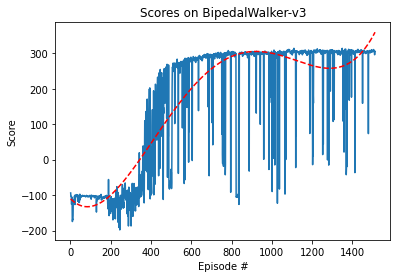

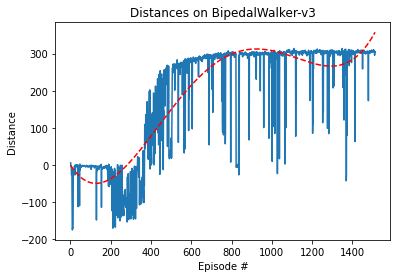

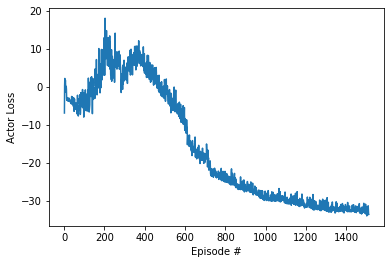

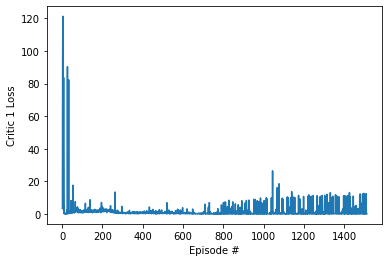

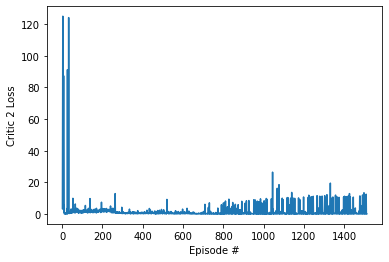

In [5]:
import torch
import gym
import numpy as np
from TD3 import TD3
from utils import ReplayBuffer
from collections import deque
import pickle
import matplotlib.pyplot as plt


######### Hyperparameters #########
gym.logger.set_level(40)
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

log_interval = 100  # print avg reward after interval
random_seed = 0
gamma = 0.99  # discount for future rewards
batch_size = 100  # num of transitions sampled from replay buffer
lr = 0.001
exploration_noise = 0.1
polyak = 0.995  # target policy update parameter (1-tau)
policy_noise = 0.2  # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2  # delayed policy updates parameter
max_episodes = 10000  # max num of episodes
max_timesteps = 2000  # max timesteps in one episode
directory = "./preTrained/"  # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)

start_episode = 0


policy = TD3(lr, state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()

if random_seed:
    print("Random Seed: {}".format(random_seed))
    env.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

LOAD = False
if LOAD:
    start_episode = 6
    policy.load(directory, filename, str(start_episode))

# logging variables:
scores = []
mean_scores = []
last_scores = deque(maxlen=log_interval)
distances = []
mean_distances = []
last_distance = deque(maxlen=log_interval)
losses_mean_episode = []

# training procedure:
for ep in range(start_episode + 1, max_episodes + 1):
    state = env.reset()
    total_reward = 0
    total_distance = 0
    actor_losses = []
    c1_losses = []
    c2_losses = []
    for t in range(max_timesteps):
        # select action and add exploration noise:
        action = policy.select_action(state)
        action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
        action = action.clip(env.action_space.low, env.action_space.high)

        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state

        total_reward += reward
        if reward != -100:
            total_distance += reward

        # if episode is done then update policy:
        if done or t == (max_timesteps - 1):
            actor_loss, c1_loss, c2_loss = policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
            actor_losses.append(actor_loss)
            c1_losses.append((c1_loss))
            c2_losses.append(c2_loss)
            break
    mean_loss_actor = np.mean(actor_losses)
    mean_loss_c1 = np.mean(c1_losses)
    mean_loss_c2 = np.mean(c2_losses)
    losses_mean_episode.append((ep, mean_loss_actor, mean_loss_c1, mean_loss_c2))
    print('\rEpisode: {}/{},\tScore: {:.2f},\tDistance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
        .format(ep, max_episodes,total_reward,total_distance,mean_loss_actor,mean_loss_c1, mean_loss_c2),end="")

    # logging updates:
    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    FILE = 'record.dat'
    data = [ep, total_reward, total_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
    with open(FILE, "ab") as f:
        pickle.dump(data, f)

    # if avg reward > 300 then save and stop traning:
    if (mean_score) >= 300:
        print("########## Solved! ###########")
        name = filename + '_solved'
        policy.save(directory, name, str(ep))
        break

    # print avg reward every log interval:
    if ep % log_interval == 0:
        policy.save(directory, filename, str(ep))
        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        print('\rEpisode: {}/{},\tMean Score: {:.2f},\tMean Distance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
            .format(ep, max_episodes, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2))
        FILE = 'record_mean.dat'
        data = [ep, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
        with open(FILE, "ab") as f:
            pickle.dump(data, f)
env.close()


# plot the scores and mean
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.plot(x, y)
fit = np.polyfit(x, y, deg=4)
p = np.poly1d(fit)
plt.plot(x, p(x), "r--")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Scores on BipedalWalker-v3')
plt.show()
namefig = "plot/scores_TD3_episodes" + str(max_episodes) + ".jpg"
fig.savefig(namefig)

# plot the distance and mean
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(distances) + 1)
y = distances
plt.plot(x, y)
fit = np.polyfit(x, y, deg=4)
p = np.poly1d(fit)
plt.plot(x, p(x), "r--")
plt.ylabel('Distance')
plt.xlabel('Episode #')
plt.title('Distances on BipedalWalker-v3')
plt.show()
namefig = "plot/distances_TD3_episodes" + str(max_episodes) + ".jpg"
fig.savefig(namefig)

episode = []
actor_loss = []
c1_loss = []
c2_loss = []
for single_loss in losses_mean_episode:
    episode.append(single_loss[0])
    actor_loss.append(single_loss[1])
    c1_loss.append(single_loss[2])
    c2_loss.append(single_loss[3])

# plot the loss
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episode, actor_loss)
plt.ylabel('Actor Loss')
plt.xlabel('Episode #')
plt.show()
namefig = "plot/actor_loss_TD3_episodes" + str(max_episodes) + ".jpg"
fig.savefig(namefig)

# plot the c1_loss
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episode, c1_loss)
plt.ylabel('Critic 1 Loss')
plt.xlabel('Episode #')
plt.show()
namefig = "plot/critic_1_loss_TD3_episodes" + str(max_episodes) + ".jpg"
fig.savefig(namefig)

# plot the c2_loss
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episode, c2_loss)
plt.ylabel('Critic 2 Loss')
plt.xlabel('Episode #')
plt.show()
namefig = "plot/critic_2_loss_TD3_episodes" + str(max_episodes) + ".jpg"
fig.savefig(namefig)